## Multi-class classification with logistic regression

In [1]:
%matplotlib inline
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
IMAGE_SIZE = 20

#### Loading data from matlab file using scipy.io.loadmat()

In [3]:
train_data = io.loadmat("ex3data1.mat")
X = train_data['X']
y = train_data['y']

#### Change output label of "0" from "10" to "0" because python index start from 0 not 1 like MATLAB

In [4]:
y[y==10] = 0

Please note that the $reshape()$ function in NUMPY and MATLAB default behavior is different,
To make $reshape()$ in numpy behave the same we add flag order="F" when call reshape function in numpy

In [5]:
def display_data(data):
    m,n = data.shape
    row_width = int(np.sqrt(m))
    img_width = img_height = int(np.sqrt(n))
    img_show = np.empty((row_width*img_width, img_width*row_width))
    for i in range(row_width):
        for j in range(row_width):
            img_show[img_height*i:(img_height*i)+img_height, img_width*j:img_width*j + img_width] = \
            np.reshape(data[i*row_width + j, :], (img_height, img_width), order='F')
            
    plt.imshow(img_show)

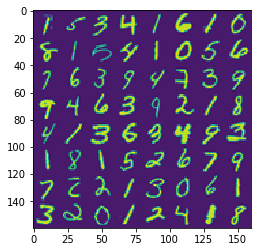

In [12]:
idx = np.random.randint(X.shape[0], size=64)
display_data(X[idx, :])